###### Content under Creative Commons Attribution license CC-BY 4.0, code under MIT license (c)2014 L.A. Barba, C.D. Cooper, G.F. Forsyth.

# Riding the wave

## Numerical schemes for hyperbolic PDEs

Welcome back! This is the second notebook of *Riding the wave: Convection problems*, the third module of  ["Practical Numerical Methods with Python"](http://openedx.seas.gwu.edu/courses/GW/MAE6286/2014_fall/about). 

The first notebook of this module discussed conservation laws and developed the non-linear traffic equation. We learned about the effect of the wave speed on the stability of the numerical method, and on the CFL number. We also realized that the forward-time/backward-space difference scheme really has many limitations: it cannot deal with wave speeds that move in more than one direction. It is also first-order accurate in space and time, which often is just not good enough. This notebook will introduce some new numerical schemes for conservation laws, continuing with the traffic-flow problem as motivation.

## Red light!

Let's explore the behavior of different numerical schemes for a moving shock wave. In the context of the traffic-flow model of the previous notebook, imagine a very busy road and a red light at $x=4$. Cars accumulate quickly in the front, where we have the maximum allowed density of cars between $x=3$ and $x=4$, and there is an incoming traffic of 50% the maximum allowed density $(\rho = 0.5\rho_{\rm max})$. 

Mathematically, this is:

\begin{equation}\rho(x,0) = \left\{ \begin{array}{cc}
0.5 \rho_{\rm max} & 0 \leq x < 3  \\
\rho_{\rm max} & 3 \leq x \leq 4 \\ \end{array} \right.\end{equation}

Let's find out what the initial condition looks like.

In [1]:
%matplotlib inline
import numpy 
from matplotlib import pyplot
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

In [2]:
def rho_red_light(nx, rho_max, rho_in):
    """Computes "red light" initial condition with shock

    Parameters
    ----------
    nx        : int
        Number of grid points in x
    rho_max   : float
        Maximum allowed car density
    rho_in    : float
        Density of incoming cars 

    Returns
    -------
    rho: array of floats
        Array with initial values of density
    """
    rho = rho_max*numpy.ones(nx)
    rho[:int((nx-1)*3./4.)] = rho_in
    return rho

In [3]:
#Basic initial condition parameters
#defining grid size, time steps, CFL condition, etc...
nx = 81
nt = 30
dx = 4.0/(nx-1)

rho_in = 5.
rho_max = 10.

u_max = 1.

x = numpy.linspace(0,4,nx)

rho = rho_red_light(nx, rho_max, rho_in)

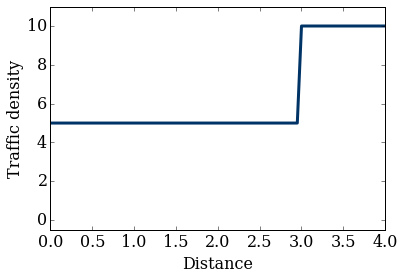

In [4]:
pyplot.plot(x, rho, color='#003366', ls='-', lw=3)
pyplot.ylabel('Traffic density')
pyplot.xlabel('Distance')
pyplot.ylim(-0.5,11.);

The question we would like to answer is: **How will cars accumulate at the red light?** 

We will solve this problem using different numerical schemes, to see how they perform. These schemes are:

   * Lax-Friedrichs
   * Lax-Wendroff
   * MacCormack

Before we do any coding, let's think about the equation a little bit. The wave speed $u_{\rm wave}$ is $-1$ for $\rho = \rho_{\rm max}$ and $\rho \leq \rho_{\rm max}/2$, making all velocities negative. We should see a solution moving left, maintaining the shock geometry.

![squarewave](./figures/squarewave.png)
#### Figure 1. The exact solution is a shock wave moving left.

Now to some coding! First, let's define some useful functions and prepare to make some nice animations later.

In [5]:
def computeF(u_max, rho_max, rho):
    """Computes flux F=V*rho

    Parameters
    ----------
    u_max  : float
        Maximum allowed velocity
    rho    : array of floats
        Array with density of cars at every point x
    rho_max: float
        Maximum allowed car density
        
    Returns
    -------
    F : array
        Array with flux at every point x
    """
    return u_max*rho*(1-rho/rho_max)

In [6]:
from matplotlib import animation
from JSAnimation.IPython_display import display_animation

In [7]:
def animate(data):
    x = numpy.linspace(0,4,nx)
    y = data
    line.set_data(x,y)
    return line,

## Lax-Friedrichs scheme

Recall the conservation law for vehicle traffic, resulting in the following equation for the traffic density:

\begin{equation} \frac{\partial \rho}{\partial t} + \frac{\partial F}{\partial x} = 0 \end{equation}

$F$ is the *traffic flux*, which in the linear traffic-speed model is given by: 

\begin{equation} F = \rho u_{\rm max} \left(1-\frac{\rho}{\rho_{\rm max}}\right)
\end{equation}

In the time variable, the natural choice for discretization is always a forward-difference formula; time invariably moves forward!

\begin{equation}\frac{\partial \rho}{\partial t}\approx \frac{1}{\Delta t}( \rho_i^{n+1}-\rho_i^n )\end{equation}

As is usual, the discrete locations on the 1D spatial grid are denoted by indices $i$ and the discrete time instants are denoted by indices $n$.

In a convection problem, using first-order discretization in space leads to excessive numerical diffusion (as you probably observed in [Lesson 1 of Module 2](http://nbviewer.ipython.org/github/numerical-mooc/numerical-mooc/blob/master/lessons/02_spacetime/02_01_1DConvection.ipynb)). The simplest approach to get second-order accuracy in space is to use a central difference:

\begin{equation}\frac{\partial F}{\partial x} \approx \frac{1}{2\Delta x}( F_{i+1}-F_{i-1})\end{equation}

But combining these two choices for time and space discretization in the convection equation has catastrophic results! The "forward-time, central scheme" (FTCS) is **unstable**. (Go on: try it; you know you want to!)

The Lax-Friedrichs scheme was proposed by Lax (1954) as a clever trick to stabilize the forward-time, central scheme. The idea was to replace the solution value at $\rho^n_i$ by the average of the values at the neighboring grid points. If we do that replacement, we get the following discretized equation: 


\begin{equation}\frac{\rho_i^{n+1}-\frac{1}{2}(\rho^n_{i+1}+\rho^n_{i-1})}{\Delta t} = -\frac{F^n_{i+1}-F^n_{i-1}}{2 \Delta x}\end{equation}

Take a careful look: the difference formula no longer uses the value at $\rho^n_i$ to obtain $\rho^{n+1}_i$. The stencil of the Lax-Friedrichs scheme is slightly different than that for the forward-time, central scheme.

![Stencil of the forward-time central scheme](./figures/FD-stencil_FTCS.png)
#### Figure 2. Stencil of the forward-time/central scheme.

![Stencil of the Lax-Friedrichs scheme](./figures/FD-stencil_LF.png)
#### Figure 3. Stencil of the Lax-Friedrichs scheme.

This numerical discretization is **stable**. Unfortunately, substituting  $\rho^n_i$ by the average of its neighbors introduces a first-order error. _Nice try, Lax!_

To implement the scheme in code, we need to isolate the value at the next time step, $\rho^{n+1}_i$, so we can write a time-stepping loop:

\begin{equation}\rho_i^{n+1} = \frac{1}{2}(\rho^n_{i+1}+\rho^n_{i-1}) - \frac{\Delta t}{2 \Delta x}(F^n_{i+1}-F^n_{i-1})\end{equation}

The function below implements Lax-Friedrichs for our traffic model.  All the schemes in this notebook are wrapped in their own functions to help with displaying animations of the results.  This is also good practice for developing modular, reusable code.

In order to display animations, we're going to hold the results of each time step in the variable `rho`, a 2D array.  The resulting array `rho_n` has `nt` rows and `nx` columns.

In [8]:
def laxfriedrichs(rho, nt, dt, dx, rho_max, u_max):
    """ Computes the solution with Lax-Friedrichs scheme
    
    Parameters
    ----------
    rho    : array of floats
            Density at current time-step
    nt     : int
            Number of time steps
    dt     : float
            Time-step size
    dx     : float
            Mesh spacing
    rho_max: float
            Maximum allowed car density
    u_max  : float
            Speed limit
    
    Returns
    -------
    rho_n : array of floats
            Density after nt time steps at every point x
    """
    
    #initialize our results array with dimensions nt by nx
    rho_n = numpy.zeros((nt,len(rho)))      
    #copy the initial u array into each row of our new array
    rho_n[:,:] = rho.copy()              
    
    '''
    Now, for each timestep, we're going to calculate rho^n+1, 
    then set the value of rho equal to rho^n+1 so we can calculate 
    the next iteration.  For every timestep, the entire vector
    rho^n is saved in a single row of our results array rho_n.
    '''
    for t in range(1,nt):
        F = computeF(u_max, rho_max, rho)
        rho_n[t,1:-1] = .5*(rho[2:]+rho[:-2]) - dt/(2*dx)*(F[2:]-F[:-2])
        rho_n[t,0] = rho[0] # boundary condition at x=0
        rho_n[t,-1] = rho[-1] # boundary condition at x=4
        rho = rho_n[t].copy()
        
    return rho_n

### Lax-Friedrichs with $\frac{\Delta t}{\Delta x}=1$

We are now all set to run! First, let's try with CFL=1

In [9]:
sigma = 1.0
dt = sigma*dx/u_max

rho = rho_red_light(nx, rho_max, rho_in)      #make sure that u is set to our expected initial conditions
rho_n = laxfriedrichs(rho, nt, dt, dx, rho_max, u_max)

We can ask NumPy to tell us the shape of our new array `rho_n` and see if we have the dimensions we're expecting.  We should have `nt` rows and `nx` columns.  

In [10]:
rho_n.shape

(30, 81)

Looks good!  Let's plot this now

In [11]:
fig = pyplot.figure();
ax = pyplot.axes(xlim=(0,4),ylim=(4.5,11),xlabel=('Distance'),ylabel=('Traffic density'));
line, = ax.plot([],[],color='#003366', lw=2);

anim = animation.FuncAnimation(fig, animate, frames=rho_n, interval=50)
display_animation(anim, default_mode='once')

##### Think

* What do you see in the animation above? How does the numerical solution compare with the exact solution (a left-traveling shock wave)? 
* What types of errors do you think we see? 
* What do you think of the Lax-Friedrichs scheme, so far?

### Lax-Friedrichs with $\frac{\Delta t}{\Delta x} = 0.5$

Would the solution improve if we use smaller time steps? Let's check that!

In [12]:
sigma = 0.5
dt = sigma*dx/u_max

rho = rho_red_light(nx, rho_max, rho_in)      #make sure that u is set to our expected initial conditions
rho_n = laxfriedrichs(rho, nt, dt, dx, rho_max, u_max)

Now that we have our new data set, we can set up the next animation.  We'll use all the same code from above, except now our `animate` function is already defined, so we can just set up a figure as before, then call `FuncAnimation`.

In [13]:
anim = animation.FuncAnimation(fig, animate, frames=rho_n, interval=50)
display_animation(anim, default_mode='once')

##### Dig deeper

Notice the strange "staircase" behavior on the leading edge of the wave?  You may be interested to learn more about this: a feature typical of what is sometimes called "odd-even decoupling." Last year we published a collection of lessons in Computational Fluid Dynamics, called _CFD Python_, where we discuss [odd-even decoupling](http://nbviewer.ipython.org/github/barbagroup/CFDPython/blob/master/lessons/19_Odd_Even_Decoupling.ipynb?create=1) .

* How does this solution compare with the previous one, where the Courant number was $\frac{\Delta t}{\Delta x}=1$?

## Lax-Wendroff scheme

The Lax-Friedrichs method uses a clever trick to stabilize the central difference in space for convection, but loses an order of accuracy in doing so. First-order methods are just not good enough for convection problems, especially when you have sharp gradients (shocks).

The Lax-Wendroff (1960) method was the _first_ scheme ever to achieve second-order accuracy in both space and time. It is therefore a landmark in the history of computational fluid dynamics.

To develop the Lax-Wendroff scheme, we need to do a bit of work. Sit down, grab a notebook and grit your teeth. We want you to follow this derivation in your own hand. It's good for you! Start with the Taylor series expansion (in the time variable) about $\rho^{n+1}$:

\begin{equation}\rho^{n+1} = \rho^n + \frac{\partial\rho^n}{\partial t} \Delta t + \frac{(\Delta t)^2}{2}\frac{\partial^2\rho^n}{\partial t^2} + \ldots \end{equation}

For the conservation law with $F=F(\rho)$, and using our beloved chain rule, we can write:

\begin{equation}\frac{\partial \rho}{\partial t} = -\frac{\partial F}{\partial x} = -\frac{\partial F}{\partial \rho} \frac{\partial \rho}{\partial x} = -J \frac{\partial \rho}{\partial x}\end{equation}

where 

\begin{equation}J = \frac{\partial F}{\partial \rho} = u _{\rm max} \left(1-2\frac{\rho}{\rho_{\rm max}} \right)\end{equation} 

is the _Jacobian_ for the traffic model. Next, we can do a little trickery:

\begin{equation} \frac{\partial F}{\partial t} = \frac{\partial F}{\partial \rho} \frac{\partial \rho}{\partial t} = J \frac{\partial \rho}{\partial t} = -J \frac{\partial F}{\partial x}\end{equation}

In the last step above, we used the differential equation of the traffic model to replace the time derivative by a spatial derivative. These equivalences imply that

\begin{equation}\frac{\partial^2\rho}{\partial t^2} = \frac{\partial}{\partial x} \left( J \frac{\partial F}{\partial x} \right) \end{equation}

Let's use all this in the Taylor expansion:

\begin{equation}\rho^{n+1} = \rho^n - \frac{\partial F^n}{\partial x} \Delta t + \frac{(\Delta t)^2}{2} \frac{\partial}{\partial x} \left(J\frac{\partial F^n}{\partial x} \right)+ \ldots \end{equation}

We can now reorganize this and discretize the spatial derivatives with central differences to get the following discrete equation:

\begin{equation}\frac{\rho_i^{n+1} - \rho_i^n}{\Delta t} = -\frac{F^n_{i+1}-F^n_{i-1}}{2 \Delta x} + \frac{\Delta t}{2} \left(\frac{(J \frac{\partial F}{\partial x})^n_{i+\frac{1}{2}}-(J \frac{\partial F}{\partial x})^n_{i-\frac{1}{2}}}{\Delta x}\right)\end{equation}

Now, approximate the rightmost term (inside the parenthesis) in the above equation as follows:
\begin{equation} \frac{J^n_{i+\frac{1}{2}}\left(\frac{F^n_{i+1}-F^n_{i}}{\Delta x}\right)-J^n_{i-\frac{1}{2}}\left(\frac{F^n_i-F^n_{i-1}}{\Delta x}\right)}{\Delta x}\end{equation}

Then evaluate the Jacobian at the midpoints by using averages of the points on either side:

\begin{equation}\frac{\frac{1}{2 \Delta x}(J^n_{i+1}+J^n_i)(F^n_{i+1}-F^n_i)-\frac{1}{2 \Delta x}(J^n_i+J^n_{i-1})(F^n_i-F^n_{i-1})}{\Delta x}.\end{equation}

Our equation now reads:

\begin{align}
&\frac{\rho_i^{n+1} - \rho_i^n}{\Delta t} =  
-\frac{F^n_{i+1}-F^n_{i-1}}{2 \Delta x} + \cdots \\ \nonumber 
&+ \frac{\Delta t}{4 \Delta x^2} \left( (J^n_{i+1}+J^n_i)(F^n_{i+1}-F^n_i)-(J^n_i+J^n_{i-1})(F^n_i-F^n_{i-1})\right)
\end{align}

Solving for $\rho_i^{n+1}$:

\begin{align}
&\rho_i^{n+1} = \rho_i^n - \frac{\Delta t}{2 \Delta x} \left(F^n_{i+1}-F^n_{i-1}\right) + \cdots \\ \nonumber 
&+ \frac{(\Delta t)^2}{4(\Delta x)^2} \left[ (J^n_{i+1}+J^n_i)(F^n_{i+1}-F^n_i)-(J^n_i+J^n_{i-1})(F^n_i-F^n_{i-1})\right]
\end{align}

with

\begin{equation}J^n_i = \frac{\partial F}{\partial \rho} = u_{\rm max} \left(1-2\frac{\rho^n_i}{\rho_{\rm max}} \right).\end{equation} 

Lax-Wendroff is a little bit long.  Remember that you can use \ slashes to split up a statement across several lines.  This can help make code easier to parse (and also easier to debug!). 

In [14]:
def Jacobian(u_max, rho_max, rho):
    return u_max*(1-2*rho/rho_max)

def laxwendroff(rho, nt, dt, dx, rho_max, u_max):
    """ Computes the solution with Lax-Wendroff scheme
    
    Parameters
    ----------
    rho    : array of floats
            Density at current time-step
    nt     : int
            Number of time steps
    dt     : float
            Time-step size
    dx     : float
            Mesh spacing
    rho_max: float
            Maximum allowed car density
    u_max  : float
            Speed limit
    
    Returns
    -------
    rho_n : array of floats
            Density after nt time steps at every point x
    """
    
    #initialize our results array with dimensions nt by nx
    rho_n = numpy.zeros((nt,len(rho)))      
    #copy the initial u array into each row of our new array
    rho_n[:,:] = rho.copy()              
    

    for t in range(1,nt):
        F = computeF(u_max, rho_max, rho)
        J = Jacobian(u_max, rho_max, rho)
        
        rho_n[t,1:-1] = rho[1:-1] - dt/(2*dx)*(F[2:]-F[:-2]) \
                           + dt**2/(4*dx**2) * ( (J[2:]+J[1:-1])*(F[2:]-F[1:-1]) \
                           - (J[1:-1]+J[:-2])*(F[1:-1]-F[:-2]) )
        
        rho_n[t,0] = rho[0]
        rho_n[t,-1] = rho[-1]
        rho = rho_n[t].copy()
        
    return rho_n

Now that's we've defined a function for the Lax-Wendroff scheme, we can use the same procedure as above to animate and view our results.  

### Lax-Wendroff with $\frac{\Delta t}{\Delta x}=1$

In [15]:
rho = rho_red_light(nx, rho_max, rho_in) 
sigma = 1
dt = sigma*dx/u_max
rho_n = laxwendroff(rho, nt, dt, dx, rho_max, u_max)

In [16]:
fig = pyplot.figure();
ax = pyplot.axes(xlim=(0,4),ylim=(4.5,11.),xlabel=('Distance'),ylabel=('Traffic density'));
line, = ax.plot([],[],color='#003366', lw=2);

anim = animation.FuncAnimation(fig, animate, frames=rho_n, interval=50)
display_animation(anim, default_mode='once')

Interesting! The Lax-Wendroff method captures the sharpness of the shock much better than the Lax-Friedrichs scheme, but there is a new problem: a strange wiggle appears right at the tail of the shock. This is typical of many second-order methods: they introduce _numerical oscillations_ where the solution is not smooth. Bummer.

### Lax-Wendroff with $\frac{\Delta t}{\Delta x} =0.5$

How do the oscillations at the shock front vary with changes to the CFL condition? You might think that the solution will improve if you make the time step smaller ... let's see.

In [17]:
rho = rho_red_light(nx, rho_max, rho_in) 
sigma = 0.5
dt = sigma*dx/u_max
rho_n = laxwendroff(rho, nt, dt, dx, rho_max, u_max)

fig = pyplot.figure();
ax = pyplot.axes(xlim=(0,4),ylim=(4.5,11),xlabel=('Distance'),ylabel=('Traffic density'));
line, = ax.plot([],[],color='#003366', lw=2);

anim = animation.FuncAnimation(fig, animate, frames=rho_n, interval=50)
display_animation(anim, default_mode='once')

Eek! The numerical oscillations got worse. Double bummer!

Why do we observe oscillations with second-order methods? This is a question of fundamental importance!

## MacCormack Scheme

The numerical oscillations that you observed with the Lax-Wendroff method on the traffic model can become severe in some problems. But actually the main drawback of the Lax-Wendroff method is having to calculate the Jacobian in every time step. With more complicated equations (like the Euler equations), calculating the Jacobian is a large computational expense.

Robert W. MacCormack introduced the first version of his now-famous method at the 1969 AIAA Hypervelocity Impact Conference, held in Cincinnati, Ohio, but the paper did not at first catch the attention of the aeronautics community. The next year, however, he presented at the 2nd International Conference on Numerical Methods in Fluid Dynamics at Berkeley. His paper there (MacCormack, 1971) was a landslide. MacCormack got a promotion and continued to work on applications of his method to the compressible Navier-Stokes equations. In 1973, NASA gave him the prestigious H. Julian Allen award for his work.

The MacCormack scheme is a two-step method, in which the first step is called a _predictor_ and the second step is called a _corrector_. It acheives second-order accuracy in both space and time. One version is as follows:  

\begin{equation}\rho^*_i = \rho^n_i - \frac{\Delta t}{\Delta x} (F^n_{i+1}-F^n_{i}) \ \ \ \ \ \ \text{(predictor)}\end{equation}

\begin{equation}\rho^{n+1}_i = \frac{1}{2} (\rho^n_i + \rho^*_i - \frac{\Delta t}{\Delta x} (F^*_i - F^{*}_{i-1})) \ \ \ \ \ \ \text{(corrector)}\end{equation}

If you look closely, it appears like the first step is a forward-time/forward-space scheme, and the second step is like a forward-time/backward-space scheme (these can also be reversed), averaged with the first result. What is so cool about this? You can compute problems with left-running waves and right-running waves, and the MacCormack scheme gives you a stable method (subject to the CFL condition). Nice! Let's try it.

In [18]:
def maccormack(rho, nt, dt, dx, u_max, rho_max):
    """ Computes the solution with MacCormack scheme
    
    Parameters
    ----------
    rho    : array of floats
            Density at current time-step
    nt     : int
            Number of time steps
    dt     : float
            Time-step size
    dx     : float
            Mesh spacing
    rho_max: float
            Maximum allowed car density
    u_max  : float
            Speed limit
    
    Returns
    -------
    rho_n : array of floats
            Density after nt time steps at every point x
    """
    
    rho_n = numpy.zeros((nt,len(rho)))
    rho_star = numpy.empty_like(rho)
    rho_n[:,:] = rho.copy()
    rho_star = rho.copy()
    
    for t in range(1,nt):
        F = computeF(u_max, rho_max, rho)
        rho_star[:-1] = rho[:-1] - dt/dx * (F[1:]-F[:-1])
        Fstar = computeF(u_max, rho_max, rho_star)
        rho_n[t,1:] = .5 * (rho[1:]+rho_star[1:] - dt/dx * (Fstar[1:] - Fstar[:-1]))
        rho = rho_n[t].copy()
        
    return rho_n

### MacCormack with $\frac{\Delta t}{\Delta x} = 1$

In [19]:
rho = rho_red_light(nx, rho_max, rho_in)
sigma = 1.0
dt = sigma*dx/u_max

rho_n = maccormack(rho,nt,dt,dx,u_max,rho_max)

fig = pyplot.figure();
ax = pyplot.axes(xlim=(0,4),ylim=(4.5,11),xlabel=('Distance'),ylabel=('Traffic density'));
line, = ax.plot([],[],color='#003366', lw=2);

anim = animation.FuncAnimation(fig, animate, frames=rho_n, interval=50)
display_animation(anim, default_mode='once')

### MacCormack with $\frac{\Delta t}{\Delta x}= 0.5$

Once again, we ask: how does the CFL number affect the errors? Which one gives better results? You just have to try it.

In [20]:
rho = rho_red_light(nx, rho_max, rho_in)
sigma = 0.5
dt = sigma*dx/u_max

rho_n = maccormack(rho,nt,dt,dx,u_max,rho_max)

fig = pyplot.figure();
ax = pyplot.axes(xlim=(0,4),ylim=(4.5,11),xlabel=('Distance'),ylabel=('Traffic density'));
line, = ax.plot([],[],color='#003366', lw=2);

anim = animation.FuncAnimation(fig, animate, frames=rho_n, interval=50)
display_animation(anim, default_mode='once')

##### Dig Deeper

You can also obtain a MacCormack scheme by reversing the predictor and corrector steps. For shocks, the best resolution will occur when the difference in the predictor step is in the direction of propagation. Try it out! Was our choice here the ideal one? In which case is the shock better resolved?

##### Challenge task

In the *red light* problem, $\rho \geq \rho_{\rm max}/2$, making the wave speed negative at all points . You might be wondering why we introduced these new methods; couldn't we have just used a forward-time/forward-space scheme? But, what if $\rho_{\rm in} < \rho_{\rm max}/2$? Now, a whole region has negative wave speeds and forward-time/backward-space is unstable. 

* How do Lax-Friedrichs, Lax-Wendroff and MacCormack behave in this case? Try it out!

* As you decrease $\rho_{\rm in}$, what happens to the velocity of the shock? Why do you think that happens?

## References

* Peter D. Lax (1954), "Weak solutions of nonlinear hyperbolic equations and their numerical computation," _Commun. Pure and Appl. Math._, Vol. 7, pp. 159–193.

* Peter D. Lax and Burton Wendroff (1960), "Systems of conservation laws,"  _Commun. Pure and Appl. Math._, Vol. 13, pp. 217–237.

* R. W. MacCormack (1969), "The effect of viscosity in hypervelocity impact cratering," AIAA paper 69-354. Reprinted on _Journal of Spacecraft and Rockets_, Vol. 40, pp. 757–763 (2003). Also on _Frontiers of Computational Fluid Dynamics_, edited by D. A. Caughey, M. M. Hafez (2002), chapter 2: [read on Google Books](http://books.google.com/books?id=QBsnMOz_8qcC&lpg=PA27&ots=uqCeuH1U6S&lr&pg=PA27#v=onepage&q&f=false).

* R. W. MacCormack (1971), "Numerical solution of the interaction of a shock wave with a laminar boundary layer," _Proceedings of the 2nd Int. Conf. on Numerical Methods in Fluid Dynamics_, Lecture Notes in Physics, Vol. 8, Springer, Berlin, pp. 151–163. 

---

###### The cell below loads the style of the notebook.

In [21]:
from IPython.core.display import HTML
css_file = '../../styles/numericalmoocstyle.css'
HTML(open(css_file, "r").read())